In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy
import itertools  
import time

In [0]:
url='https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz'

In [0]:
coloumn_names=['Class_Label','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET',' M_R', 
               'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

In [0]:
PM_DF=pd.read_csv(url,header=None,index_col=False,names=coloumn_names)

In [0]:
Features=PM_DF.drop('Class_Label',axis=1)

In [0]:
Labels=PM_DF['Class_Label']

In [0]:
print(Features.shape , Labels.shape)

(5000000, 18) (5000000,)


In [0]:
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer

In [0]:
x_train,x_test,y_train,y_test=train_test_split(Features,Labels,test_size=0.33,random_state=1,shuffle=True)

In [0]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(3350000, 18) (1650000, 18) (3350000,) (1650000,)


In [0]:
print(GradientBoostingClassifier())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [0]:
GB_MODEL=GradientBoostingClassifier()

In [0]:
GB_MODEL.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
y_pred=GB_MODEL.predict(x_test)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [0]:
cnf_matrix = confusion_matrix(y_test, y_pred)

Normalized confusion matrix
[[0.87146005 0.12853995]
 [0.28744054 0.71255946]]


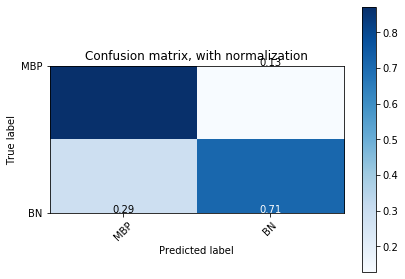

In [0]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['MBP','BN'],
                      title='Confusion matrix, with normalization')

In [0]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  779616
False Positives:  114993
False Negatives:  217130
True Positives:  538261


In [0]:
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:".format(Accuracy))

Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))

#Recall 
Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))

#F1 Score
f1 = (2*Precision*Recall)/(Precision + Recall)
print("F1 Score {:0.2f}".format(f1))

Accuracy 79.87%:
Precision 0.82
Recall 0.71
F1 Score 0.76


In [0]:
GB_MODEL.score(x_test,y_test)

0.7987133333333334

In [0]:
F_imp=pd.Series(GB_MODEL.feature_importances_,index=Features.columns)

In [0]:
nfolds = 10
def tn(y_true, y_pred): 
	return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): 
	return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): 
	return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): 
	return confusion_matrix(y_true, y_pred)[1, 1]

In [0]:
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn),
           'ac' : make_scorer(accuracy_score),
           're' : make_scorer(recall_score),
           'pr' : make_scorer(precision_score),
           'f1' : make_scorer(f1_score),
           'auc' : make_scorer(roc_auc_score),
          } 

In [0]:
import sklearn.metrics as metrics
probs = GB_MODEL.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

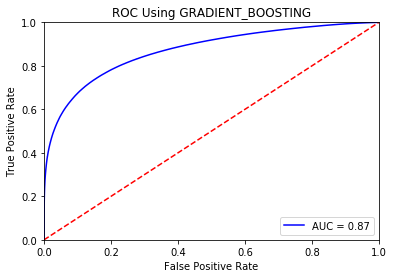

In [0]:
import matplotlib.pyplot as plt
plt.title('ROC Using GRADIENT_BOOSTING')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
cv_results = cross_validate(GB_MODEL, x_train, y_train, scoring=scoring, cv=StratifiedKFold(n_splits=nfolds, random_state=1))

In [0]:
print('Cross Validation scores (nfolds = %d):'% nfolds)
print('tp: ', cv_results['test_tp'], '; mean:', cv_results['test_tp'].mean())
print('fn: ', cv_results['test_fn'], '; mean:', cv_results['test_fn'].mean())
print('fp: ', cv_results['test_fp'], '; mean:', cv_results['test_fp'].mean())
print('tn: ', cv_results['test_tn'], '; mean:', cv_results['test_tn'].mean())
print('ac: ', cv_results['test_ac'], '; mean:', cv_results['test_ac'].mean())
print('re: ', cv_results['test_re'], '; mean:', cv_results['test_re'].mean())
print('pr: ', cv_results['test_pr'], '; mean:', cv_results['test_pr'].mean())
print('f1: ', cv_results['test_f1'], '; mean:', cv_results['test_f1'].mean())
print('auc: ', cv_results['test_auc'], '; mean:', cv_results['test_auc'].mean())